<a href="https://colab.research.google.com/github/viniciusrpb/cic0193_machinelearning/blob/main/cap2_2_feature_extraction_lbp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
cp -r "/content/drive/My Drive/leafs" "leafs"

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from imageio import imread
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
from skimage import feature

In [5]:
def get_patches(img_file, random_state, patch_size=(11, 11), n_patches=250):
    '''Extracts subimages
       Parameters
           img_file: path for an image
           patch_size: size of each patch
           n_patches: number of patches to be extracted
    '''

    img = imread(img_file)
    
    # Extract subimages
    patch = extract_patches_2d(img, 
                               patch_size=patch_size,
                               max_patches=n_patches, 
                               random_state=random_state)
    
    return patch.reshape((n_patches, 
                          np.prod(patch_size) * len(img.shape)))

Patches extracted to create dictionary of features
Total of images =  75
Size of each array of patches =  (250, 675)


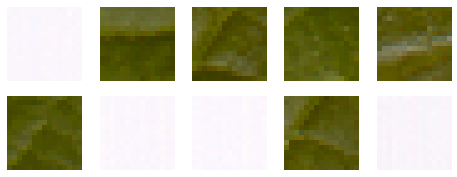

In [8]:
# BOF parameters
tam_patch = (15, 15)
n_patches = 250
path_imgs = 'leafs/leaf1/'
random_state = 1

# get list of files
l_imgs = listdir(path_imgs)
# total of images
n_imgs = len(l_imgs)

# Extract patches in parallel
# returns a list of the same size of the number of images
patch_arr = Parallel(n_jobs=-1)(delayed(get_patches)(path_imgs+arq_img, 
                                                    random_state,
                                                    tam_patch,
                                                    n_patches)
                                for arq_img in l_imgs)

print('Patches extracted to create dictionary of features')
print('Total of images = ', len(patch_arr))
print('Size of each array of patches = ', patch_arr[0].shape)

# shows some image patches
img_ind = 32
plt.figure(figsize=(8,3))
for i in np.arange(1,11):
    plt.subplot(2,5,i)
    plt.imshow(patch_arr[img_ind][i].reshape((tam_patch[0],tam_patch[1],3)))
    plt.axis('off')

In [9]:
def lbp_features(img, radius=1, sampling_pixels=8):
    
    # LBP operates in single channel images so if RGB images are provided
    # we have to convert it to grayscale
    if (len(img.shape) > 2):
        img = img.astype(float)
        # RGB to grayscale convertion using Luminance
        img = img[:,:,0]*0.3 + img[:,:,1]*0.59 + img[:,:,2]*0.11

    # converting to uint8 type for 256 graylevels
    img = img.astype(np.uint8)
    
    # normalize values can also help improving description
    i_min = np.min(img)
    i_max = np.max(img)
    if (i_max - i_min != 0):
        img = (img - i_min)/(i_max-i_min)
    
    # compute LBP
    lbp = feature.local_binary_pattern(img, sampling_pixels, radius, method="uniform")
    
    # LBP returns a matrix with the codes, so we compute the histogram
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, sampling_pixels + 3), range=(0, sampling_pixels + 2))

    # normalization
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    # return the histogram of Local Binary Patterns
    return hist

In [10]:
patch_arr = np.array(patch_arr, copy=True)
patch_arr = patch_arr.reshape((patch_arr.shape[0] * patch_arr.shape[1],
                               tam_patch[0],tam_patch[0],3))

# obtaining features lbp for each patch
patch_lbp = []
for pat in patch_arr:
        f = lbp_features(pat,2,8)
        patch_lbp.append(f)

patch_lbp = np.array(patch_lbp, copy=False)
print('Instances = ', len(patch_lbp), ' size = ', patch_lbp[0].shape[0])
print('Created LBP feature spaces')
print('\tpatches = ', len(patch_lbp), ' size = ', patch_lbp[0].shape[0])

Instances =  18750  size =  10
Created LBP feature spaces
	patches =  18750  size =  10


In [11]:
n_dic = 50 # size of the dictionary
random_state = 1

# Define a KMeans clustering model
kmeans_model = KMeans(n_clusters=n_dic, 
                      verbose=False, 
                      init='random',
                      random_state=random_state, 
                      n_init=3)
# fit the model
kmeans_model.fit(patch_lbp)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
       n_clusters=50, n_init=3, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=False)

(-0.010444444398024694,
 0.21933333235851854,
 -0.015333333265185187,
 0.32199999856888895)

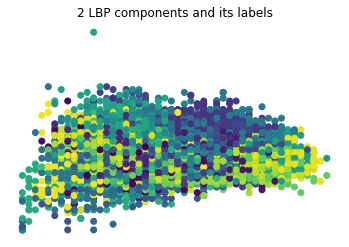

In [12]:

plt.scatter(patch_lbp[:, 0], patch_lbp[:, 1], c=kmeans_model.labels_)
plt.title('2 LBP components and its labels')
plt.axis('off')

In [13]:
# compute features for each image
img_feats = []
for i in range(n_imgs):
    # predicting n_patches of an image
    y = kmeans_model.predict(patch_lbp[i*n_patches: (i*n_patches)+n_patches])

    # computes histogram and append in the array
    hist_bof,_ = np.histogram(y, bins=range(n_dic+1), density=True)
    img_feats.append(hist_bof)

img_feats = np.array(img_feats, copy=False)
print('Number of images and features = ', img_feats.shape)

Number of images and features =  (75, 50)
